In [1]:
import sys

import numpy as np
import torch
from torch.utils.data import DataLoader
from captum.attr import GuidedGradCam
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [2]:
sys.path.append("../src")
from dataset import FSDDataset
from model import ConformerModel, GRUModel, ResNet, CRNN

In [3]:
def attribute_image_features(algorithm, input, label, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=label, **kwargs)
    
    return tensor_attributions

In [4]:
dataset = FSDDataset(
    audio_path='../../dataset',
    metadata_path='../meta/training_not_mout.csv',
    win_size_rate=0.025,
    overlap=0.5,
    n_mels=32,
    training=True,
    n_channels=1,
)
# dataloader = DataLoader(dataset, batch_size=2, pin_memory=True)

In [5]:
data1, label1 = dataset[0]
data2, label2 = dataset[1]
data = np.array([data1, data2])
labels = np.array([label1, label2])

data = torch.from_numpy(data.astype(np.float32)).clone()
# input = data.unsqueeze(0)
input = data
input.requires_grad = True

In [6]:
state_dict = torch.load('../results/20210627092226/fold0-best.pt', map_location=torch.device('cpu'))
# state_dict.keys()

In [7]:
model = ConformerModel().cpu()
model.load_state_dict(state_dict)
model = model.to('cpu')

In [8]:
# ggc = GuidedGradCam(model, model.eval().output_layer.weight)
# attr_ggc = attribute_image_features(ggc, input, labels[0].item())
# attr_ggc = np.transpose(attr_ggc.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

# _ = viz.visualize_image_attr(attr_ggc, original_image, method="blended_heat_map",sign="all",show_colorbar=True, title="GuidedGradCam")

In [9]:
saliency = Saliency(model)
grads = saliency.attribute(input, target=labels[0].item())
grads = np.transpose(grads[0].cpu().detach().numpy(), (1, 2, 0))

In [10]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input, label=labels[0].item(), baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([5.1540, 1.2547], dtype=torch.float64)


In [11]:
dl = DeepLift(model)
attr_dl = attribute_image_features(dl, input, labels[0].item(), baselines=input * 0)
attr_dl = np.transpose(attr_dl[0].cpu().detach().numpy(), (1, 2, 0))

/home/kajiwara21/work/B4Lecture-2021/ex_9/kajiwara/kajiwara_env/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [12]:
original_image = np.transpose((input[0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

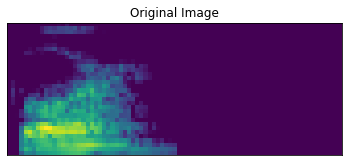

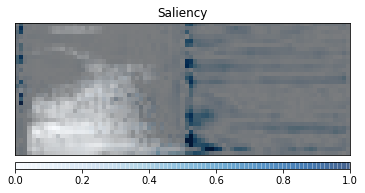

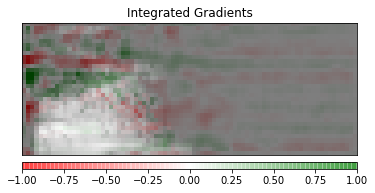

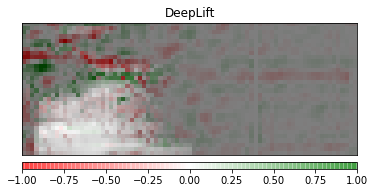

In [14]:
_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Saliency")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Integrated Gradients")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="DeepLift")